# Figure 1A and 1B from metapredict V3 manuscript 2024

In [2]:
import os
import metapredict as meta
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
import protfasta
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'
# set fonts
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

# set colors for plots here. Colors are for V1, v2, and v3. Chosen because Ryan can differentiate them.
v1color='#FF9D33'
v2color='#FF6433'
v3color='#CC2D46'
hybridcolor='black'
pLDDT_color='blue'


# NOTE! PLEASE DOWNLOAD THE .caid files for CAID2 from https://caid.idpcentral.org/assets/sections/challenge/static/predictions/2/predictions.zip
# this will download a file called 'predictions.zip' that you need to unzip in this folder to get this to work! 

In [20]:
if 'predictions' not in os.listdir():
    print("ERROR! You PLEASE DOWNLOAD THE .caid files for CAID2 from \nhttps://caid.idpcentral.org/assets/sections/challenge/static/predictions/2/predictions.zip \nthis will download a file called 'predictions.zip' that you need to unzip in this folder to get this to work!")

ERROR! You PLEASE DOWNLOAD THE .caid files for CAID2 from 
https://caid.idpcentral.org/assets/sections/challenge/static/predictions/2/predictions.zip 
this will download a file called 'predictions.zip' that you need to unzip in this folder to get this to work!


In [7]:
# Function to read in the CAID data from the fasta provided by CAID.
# read in the disorder_pdb.fasta
def read_caid_seq_disorder(caid_file):
    '''
    function to read in the modified Caid2 
    fasta file that includes a header, the
    ID, the sequence, and then the scores as
    1 = disorder, 0 = not disordered, and 
    - = not assessed.
    
    Parameters
    ----------
    caid_file : str
        path to caid file as a str

    Returns
    --------
    seqs : dict
        dictionary of sequences and scores,
        keyed by ID
    '''
    caid_seqs_scores = {}
    PATH = os.path.dirname(os.path.realpath(caid_file))
    with open(f'{PATH}/{caid_file}', 'r') as fh:
        lines=fh.readlines()
    fh.close()

    # get seqs and lines
    seq_ind=0
    for n in range(0, len(lines),3):
        caid_seqs_scores[lines[n].strip()]={'sequence':lines[n+1].strip(), 'scores':lines[n+2].strip()}
    return caid_seqs_scores

# function tocalculate mcc
def calc_mcc(predictor_scores, actual_scores):
    '''
    parameters
    -----------
    predictor_scores : list
        list of predictor scores Disorder=1, order=0
        

    actual_scores : list
        list of actual scores. Disorder=1, order=0
    returns
    -------
    mcc_value : float
        The matthews correlation coefficient value as defined in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4406047/
    '''
    true_positive=0
    false_positive=0
    true_negative=0
    false_negative=0
    for i in range(0, len(predictor_scores)):
        predicted=predictor_scores[i]
        actual=actual_scores[i]
        if predicted==1 and actual==1:
            true_positive=true_positive+1
        elif predicted==1 and actual==0:
            false_positive=false_positive+1
        elif predicted==0 and actual==0:
            true_negative=true_negative+1
        elif predicted==0 and actual==1:
            false_negative=false_negative+1

    numerator = ((true_positive * true_negative) - (false_positive * false_negative))
    denomenator_before_square = ((true_positive+false_positive)*(true_negative+false_positive)*(true_positive+false_negative)*(true_negative+false_negative))
    denomenator = math.sqrt(denomenator_before_square)
    mcc_value = numerator / denomenator
    return mcc_value

# Functions to read in CAID dataset to get MCC
# read in the caid2 data
caid2_dat=read_caid_seq_disorder('caid2_disorder_pdb.fasta')

def read_caid_convert_get_MCC_allow_altered_cutoff(caid_file, cutoff=0.5):
    '''
    reads in a .caid file and then returns the per residue 
    error. Assumes 0.5 cutoff for disorder because I can't find any
    info on cutoffs anywhere on the caid website. 
    
    Parameters
    ----------
    caid_file : str
        path to caid file as a string.
        
    cutoff : float
        disorder cutoff value
    
    Returns
    -------
    mcc : float
        error per residue as a float
    '''
    caid_vals=[]
    predictor_vals=[]
    predictor_vals_raw=[]
    total=0
    with open(caid_file, 'r') as fh:
        preds=fh.read().split('>')
        for p in preds:
            if p != '':
                pred_lines=p.split('\n')
                name=pred_lines[0]
                if '\t' in name:
                    name=name.split('\t')[0]
                # get current data for that protein.
                curdat=caid2_dat[f'>{name}']['scores']
                score_ind=0
                for v in pred_lines:
                    splitvals=v.split('\t')
                    # now need to get the prediction value. This is tricky because
                    # the formatting is inconsistent across the files. yay.
                    if len(splitvals)>=3:
                        if len(splitvals)==4:
                            if splitvals[-1]=='':
                                rawval=float(splitvals[-2])
                                if rawval>=cutoff:
                                    curpred=1
                                else:
                                    curpred=0
                            else:
                                curpred=int(splitvals[-1])
                                rawval=float(splitvals[-2])
                        elif len(splitvals)==3:
                            rawval=float(splitvals[-1])
                            if rawval>=cutoff:
                                curpred=1
                            else:
                                curpred=0
                        actual = curdat[score_ind]
                        if actual!='-':
                            caid_vals.append(int(actual))
                            predictor_vals.append(curpred)
                            predictor_vals_raw.append(rawval)
                        score_ind+=1
                        total+=1
    fh.close()
    mcc=calc_mcc(predictor_vals, caid_vals)
    return mcc


def read_caid_convert_get_MCC(caid_file):
    '''
    Reads in a caid file. This will not modify a cutoff value
    and will fail if the binary score does not exist. 
    
    Parameters
    ----------
    caid_file : str
        path to caid file as a string.
    
    Returns
    -------
    MCC : float
        MCC value
    '''
    caid_vals=[]
    predictor_vals=[]
    total=0
    with open(caid_file, 'r') as fh:
        preds=fh.read().split('>')
        for p in preds:
            if p != '':
                pred_lines=p.split('\n')
                name=pred_lines[0]
                if '\t' in name:
                    name=name.split('\t')[0]
                # get current data for that protein.
                curdat=caid2_dat[f'>{name}']['scores']
                score_ind=0
                for v in pred_lines:
                    splitvals=v.split('\t')
                    # now need to get the prediction value. This is tricky because
                    # the formatting is inconsistent across the files. yay.
                    if len(splitvals)>=3:
                        if len(splitvals)==4:
                            curpred=int(splitvals[-1])
                            actual = curdat[score_ind]
                            if actual!='-':
                                caid_vals.append(int(actual))
                                predictor_vals.append(curpred)
                            
                            score_ind+=1
                            total+=1
    fh.close()
    mcc=calc_mcc(predictor_vals, caid_vals)
    return mcc
           

In [9]:
# Caid 1 data read into a dict.
# caid1 data for metapredict networks.  in metapredict/analysis/caid2_analysis.py
caid1_metapredict_data={'V1': {'AUC':0.86599, 'APS':0.79102, 'MCC':0.58551},'V2': {'AUC':0.90677, 'APS':0.84753, 'MCC':0.69964},'V3': {'AUC':0.91455, 'APS':0.86163, 'MCC':0.71218}}

# now for the caid1 data (not metapredict)
# these are the values for MCC using default threshold values. Copied from CAID1 - https://openebench.bsc.es/benchmarking/OEBC011/OEBX0110000002/participants, column 'dataset_default_thr_mcc'
caid1_disprot_pdb_mcc={'SPOT-Disorder2': 0.706, 'SPOT-Disorder1': 0.691, 'AUCpreD': 0.661, 'RawMSA': 0.624, 'SPOT-Disorder-Single': 0.614, 'DISOPRED-3-1': 0.609, 'AUCpreD-np': 0.597, 'IUPred-long': 0.587, 'IUPred2A-long': 0.583, 'IsUnstruct': 0.57, 'Predisorder': 0.568, 'IUPred2A-short': 0.559, 'IUPred-short': 0.555, 'MobiDB-lite': 0.551, 'ESpritz-X': 0.549, 'ESpritz-N': 0.536, 'VSL2B': 0.524, 'RONN': 0.518, 'DisoMine': 0.514, 'flDPlr': 0.512, 'PyHCA': 0.49, 'FoldUnfold': 0.462, 'flDPnn': 0.429, 'DisEMBL-465': 0.411, 'ESpritz-D': 0.407, 'GlobPlot': 0.326, 'S2D-2': 0.261, 'S2D-1': 0.26, 'DisEMBL-HL': 0.252, 'DisPredict-2': 0.232, 'DynaMine': 0.105, 'DFLpred': -0.029}
# these are the values for AUCROC. Copied from CAID1 - https://openebench.bsc.es/benchmarking/OEBC011/OEBX0110000002/participants, column 'aucroc'. 
caid1_disprot_pdb_auc={'SPOT-Disorder2': 0.92, 'SPOT-Disorder1': 0.918, 'AUCpreD': 0.906, 'SPOT-Disorder-Single': 0.896, 'RawMSA': 0.894, 'AUCpreD-np': 0.883, 'Predisorder': 0.878, 'DISOPRED-3-1': 0.875, 'flDPnn': 0.873, 'IsUnstruct': 0.868, 'IUPred-long': 0.864, 'VSL2B': 0.863, 'IUPred2A-long': 0.862, 'ESpritz-X': 0.861, 'flDPlr': 0.859, 'DisoMine': 0.858, 'IUPred2A-short': 0.858, 'IUPred-short': 0.857, 'ESpritz-D': 0.856, 'MobiDB-lite': 0.844, 'RONN': 0.843, 'ESpritz-N': 0.839, 'DynaMine': 0.829, 'PyHCA': 0.822, 'S2D-1': 0.805, 'DisEMBL-465': 0.777, 'S2D-2': 0.758, 'FoldUnfold': 0.736, 'GlobPlot': 0.71, 'DisEMBL-HL': 0.697, 'DisPredict-2': 0.667, 'DFLpred': 0.379}

# add caid1 metapredict data to caid1_disport_pdb_mcc and caid1_disprot_pdb_auc
caid1_disprot_pdb_mcc['metapredict V1']=caid1_metapredict_data['V1']['MCC']
caid1_disprot_pdb_auc['metapredict V1']=caid1_metapredict_data['V1']['AUC']
caid1_disprot_pdb_mcc['metapredict V3']=caid1_metapredict_data['V3']['MCC']
caid1_disprot_pdb_auc['metapredict V3']=caid1_metapredict_data['V3']['AUC']

In [24]:
# read caid2 data into a dict
#"print_current_network_accuracy(evaluation='caid2')" in metapredict/analysis/caid2_analysis.py
caid2_metapredict_data={'V1': {'AUC': 0.89207, 'APS': 0.82545, 'MCC':0.6351},'V2': {'AUC':0.92277, 'APS': 0.87755, 'MCC':0.75701},'V3': {'AUC':0.93335, 'APS':0.89499, 'MCC':0.76869}}
# AUC values copied from from caid.idpcentral.org/challenge/results
caid2_disprot_pdb_auc_data={'SPOT-Disorder2':0.949, 'AlphaFold-rsa':0.944, 'PredIDR-long':0.934, 'IDP-Fusion':0.933, 'SPOT-Disorder':0.931, 'SETH-0':0.930, 'AlphaFold-pLLDDT':0.929, 'PredIDR-short':0.927, 'DeepIDP-2L':0.922, 'AUCpreD-profile':0.922, 'DisoPred':0.919, 'SPOT-Disorder-Single':0.917, 'SETH-1':0.911, 'rawMSA':0.910, 'ENSHROUD-all':0.906, 'AIUPred':0.903, 'flDPlr':0.899, 'ESpiritz-D':0.899, 'pyHCA':0.898, 'Dispredict3':0.895, 'flDPnn2':0.894, 'AUCpreD-no-profile':0.893, 'PreDisorder':0.893, 'VSL2':0.887, 'disomine':0.886, 'IUPred3':0.885, 'IsUnstruct':0.885, 'flDPnn':0.883, 'ESpiritz-X':0.882, 'DISOPRED3-diso':0.879, 'flDPlr2':0.879, 'MobiDB-lite':0.868, 'ESpiritz-N':0.859, 'RONN':0.857, 'DisEMBL-dis465':0.792, 's2D':0.771, 'FoldUnfold':0.708, 'DisEMBL-disHL':0.704, 'Dispredict2':0.671}

# get list of caid predictors that should exist *and have binarized scores*. 
caid2_predictors_with_binarized_scores=['VSL2.caid','AUCpred-no-profile.caid','SPOT-Disorder.caid','SPOT-Disorder-Single.caid','flDPnn.caid','pyHCA.caid','DeepIDP-2L.caid','AIUPred.caid','ESpritz-X.caid','ENSHROUD-all.caid','PredIDR-short.caid','IDP-Fusion.caid','IsUnstruct.caid','DisoPred.caid','SETH-1.caid','MobiDB-lite.caid','DISOPRED3-diso.caid','SPOT-Disorder2.caid','IUPred3.caid','ESpritz-N.caid','PreDisorder.caid','APOD.caid','flDPlr2.caid','SETH-0.caid','AUCpred-profile.caid','Dispredict3.caid','flDPtr.caid','PredIDR-long.caid','s2D.caid','ESpritz-D.caid','flDPnn2.caid','Dispredict2.caid']

# dict that lack binarized scores but *do have publicly available disorder cutoff thresholds that I could find*. values == threshold. 
caid2_predictors_without_binarized_scores={'AlphaFold-rsa.caid': 0.581, 'AlphaFold-disorder.caid':0.312, 'RONN.caid':0.5, 'FoldUnfold.caid':0.5}

# make dictionaries of the caid2 stuff. 
caid2_disprot_pdb_mcc={}
caid2_disprot_pdb_auc={}

# get MCC for predictors with provided binarized scores
for v in caid2_predictors_with_binarized_scores:
    try:
        dat = read_caid_convert_get_MCC(f'./predictions/{v}')
        caid2_disprot_pdb_mcc[v.split('.caid')[0]]=dat
    except:
        print(f'Error reading in {v}')
        
    

# get MCC for predictors without provided binarized scores but with known cutoff
for v in caid2_predictors_without_binarized_scores:
    cutoff=caid2_predictors_without_binarized_scores[v]
    try:
        dat = read_caid_convert_get_MCC_allow_altered_cutoff(f'./predictions/{v}', cutoff=cutoff)
        caid2_disprot_pdb_mcc[v.split('.caid')[0]]=dat
    except:
        print(f'Error reading in {v}')
        
# read in AUC data. 
for v in caid2_disprot_pdb_auc_data:
    caid2_disprot_pdb_auc[v]=caid2_disprot_pdb_auc_data[v]

# add metapredict data 
caid2_disprot_pdb_mcc['metapredict V1']=caid2_metapredict_data['V1']['MCC']
caid2_disprot_pdb_auc['metapredict V1']=caid2_metapredict_data['V1']['AUC']
caid2_disprot_pdb_mcc['metapredict V3']=caid2_metapredict_data['V3']['MCC']
caid2_disprot_pdb_auc['metapredict V3']=caid2_metapredict_data['V3']['AUC']

Error reading in FoldUnfold.caid


In [11]:
# Fig 1A and 1B plots
# order the CAID1 MCC values
caid1_ordered_scores_mcc_sorted=dict(sorted(caid1_disprot_pdb_mcc.items(), key=lambda item: item[1], reverse=True))
caid1_ordered_names_mcc=list(caid1_ordered_scores_mcc_sorted.keys())
caid1_ordered_scores_mcc=list(caid1_ordered_scores_mcc_sorted.values())

# order CAID2 MCC values
caid2_ordered_scores_mcc_sorted=dict(sorted(caid2_disprot_pdb_mcc.items(), key=lambda item: item[1], reverse=True))
caid2_ordered_names_mcc=list(caid2_ordered_scores_mcc_sorted.keys())
caid2_ordered_scores_mcc=list(caid2_ordered_scores_mcc_sorted.values())

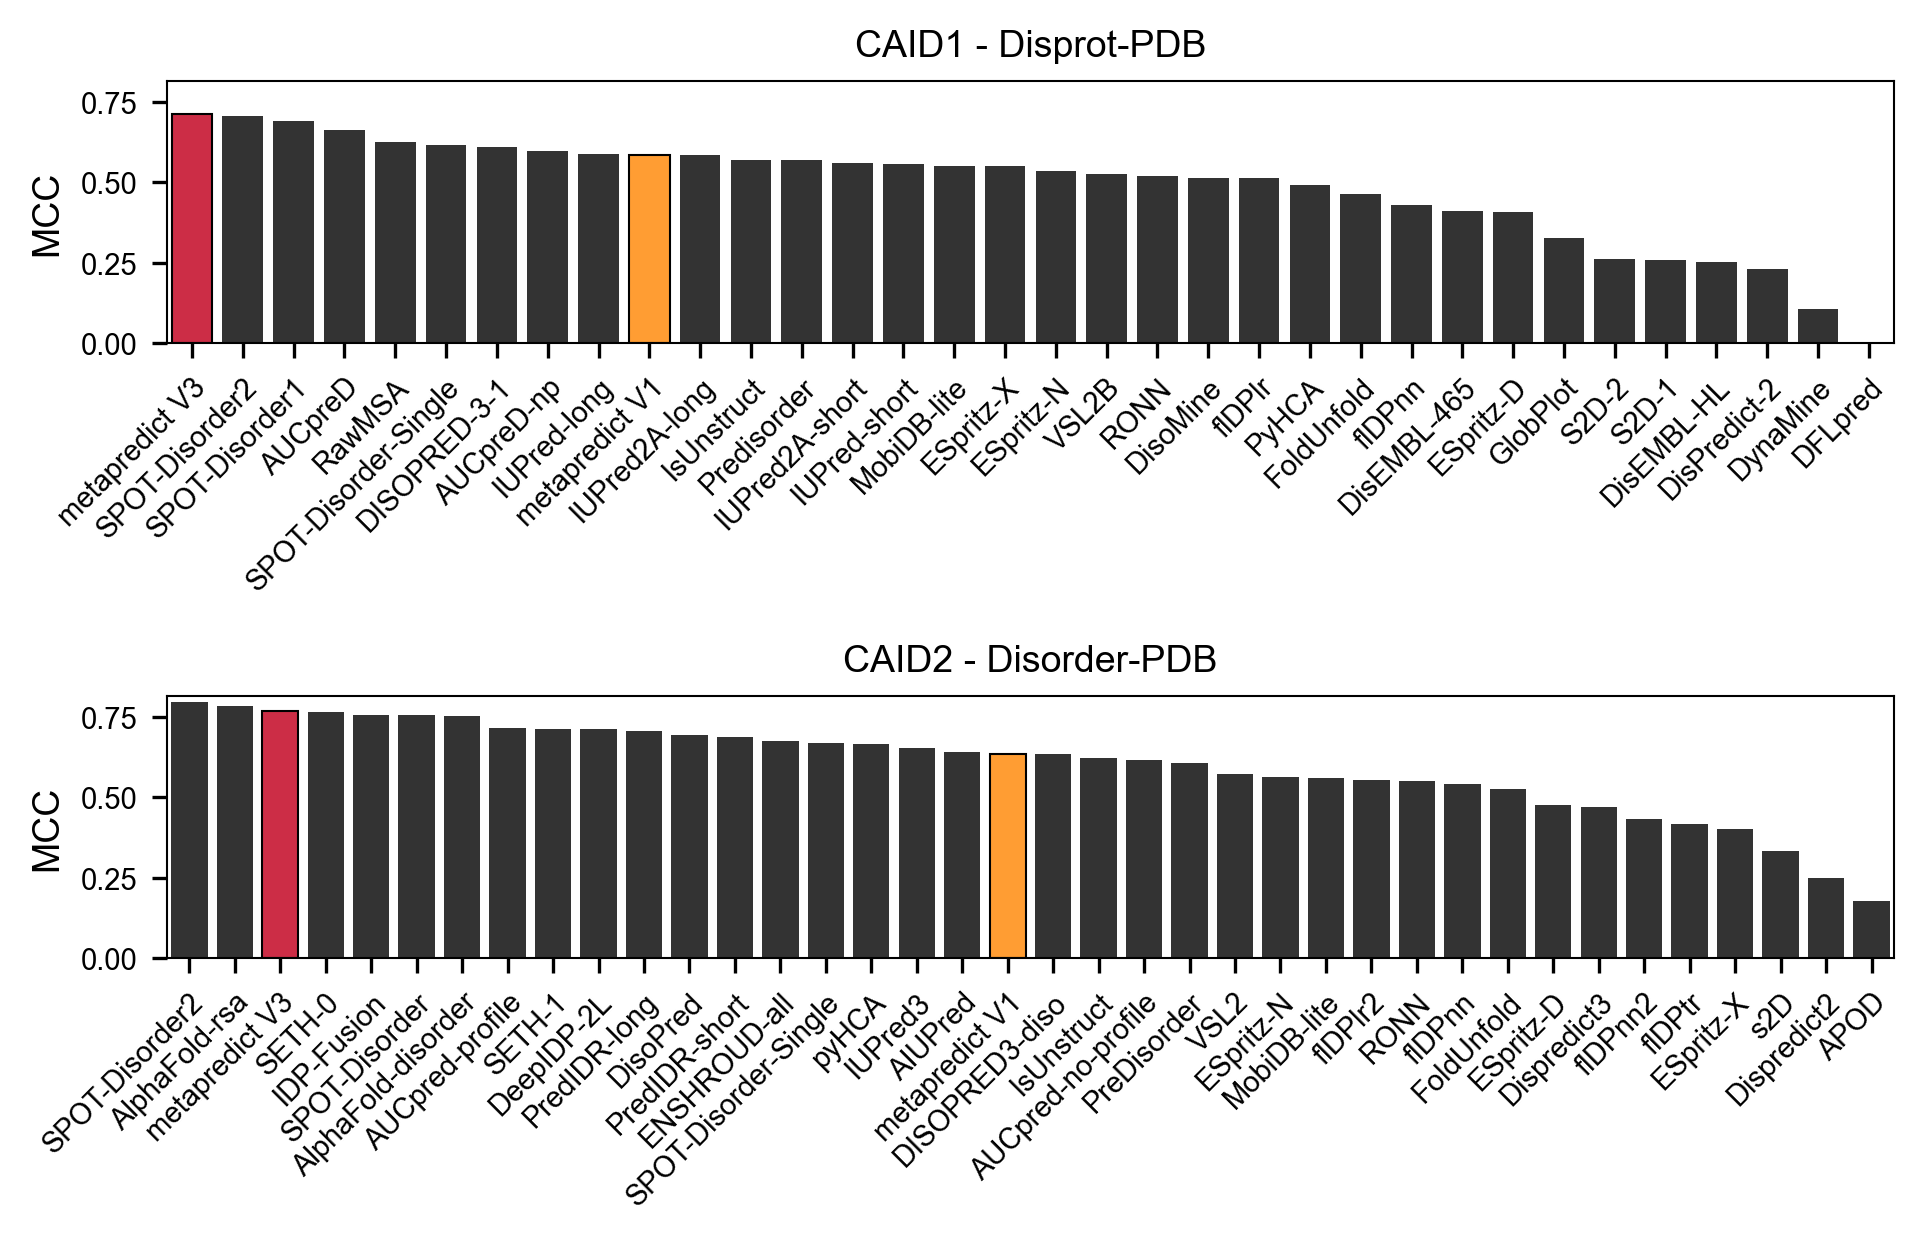

In [13]:
figure, [c1, c2]=plt.subplots(nrows=2, dpi=150, figsize=[6.5,4.25])

# plot CAID1
c1.bar(np.arange(1,len(caid1_ordered_scores_mcc)+1), caid1_ordered_scores_mcc, color='k', alpha=0.8)
c1.set_ylabel('MCC',fontsize=9)
c1.set_xticks(np.arange(1,len(caid1_ordered_names_mcc)+1), caid1_ordered_names_mcc, fontsize=7, rotation=45, horizontalalignment="right", rotation_mode='anchor')
c1.tick_params(axis='y', labelsize=7)
c1.tick_params(axis='x', labelsize=7)
c1.set_title('CAID1 - Disprot-PDB', fontsize=9)
c1.bar(caid1_ordered_names_mcc.index('metapredict V3')+1, caid1_ordered_scores_mcc[caid1_ordered_names_mcc.index('metapredict V3')], color=v3color,  linewidth=0.5, edgecolor='black')
c1.bar(caid1_ordered_names_mcc.index('metapredict V1')+1, caid1_ordered_scores_mcc[caid1_ordered_names_mcc.index('metapredict V1')], color=v1color,  linewidth=0.5, edgecolor='black')
c1.set_xlim([0.5,len(caid1_ordered_scores_mcc)+0.5])
# plot CAID2
c2.bar(np.arange(1,len(caid2_ordered_scores_mcc)+1), caid2_ordered_scores_mcc, color='k', alpha=0.8)
c2.set_ylabel('MCC',fontsize=9)
c2.set_xticks(np.arange(1,len(caid2_ordered_names_mcc)+1), caid2_ordered_names_mcc, fontsize=7, rotation=45, horizontalalignment="right", rotation_mode='anchor')
c2.tick_params(axis='y', labelsize=7)
c2.tick_params(axis='x', labelsize=7)
c2.set_title('CAID2 - Disorder-PDB', fontsize=9)
c2.bar(caid2_ordered_names_mcc.index('metapredict V3')+1, caid2_ordered_scores_mcc[caid2_ordered_names_mcc.index('metapredict V3')], color=v3color,  linewidth=0.5, edgecolor='black')
c2.bar(caid2_ordered_names_mcc.index('metapredict V1')+1, caid2_ordered_scores_mcc[caid2_ordered_names_mcc.index('metapredict V1')], color=v1color,  linewidth=0.5, edgecolor='black')
c2.set_xlim([0.5,len(caid2_ordered_scores_mcc)+0.5])

max_y=max([max(caid1_ordered_scores_mcc),max(caid2_ordered_scores_mcc)])
c2.set_ylim([0,max_y+0.02])
c1.set_ylim([0,max_y+0.02])


plt.tight_layout()
plt.savefig('Fig1A_1B.pdf')
